<a href="https://colab.research.google.com/github/lastinm/s3_hakaton_group10/blob/main/%D0%A5%D0%B0%D0%BA%D0%B0%D1%82%D0%BE%D0%BD_3_%D1%81%D0%B5%D0%BC%D0%B5%D1%81%D1%82%D1%80_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA в NLP: идеи проверок

# Шаг 1: Анализ баланса классов

In [19]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Полный путь к zip файлу
zip_file_path = '/content/drive/MyDrive/Data/geo-reviews-dataset-2023.zip'
# Имя CSV файла внутри архива
csv_file_name = 'geo-reviews-dataset-2023_1.csv'

# Чтение CSV файла напрямую из zip архива
df = pd.read_csv('/content/drive/MyDrive/Data/geo-reviews-dataset-2023.zip', compression='zip', header=0, sep='|')
df.head()

,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...


In [21]:
# Считаем количество записей в каждом классе
class_balance = df['rating'].value_counts().sort_index()
print(class_balance)

rating
0       200
1     34351
2     12088
3     21686
4     41160
5    390515
Name: count, dtype: int64


## Шаг 2: Визуализация баланса классов

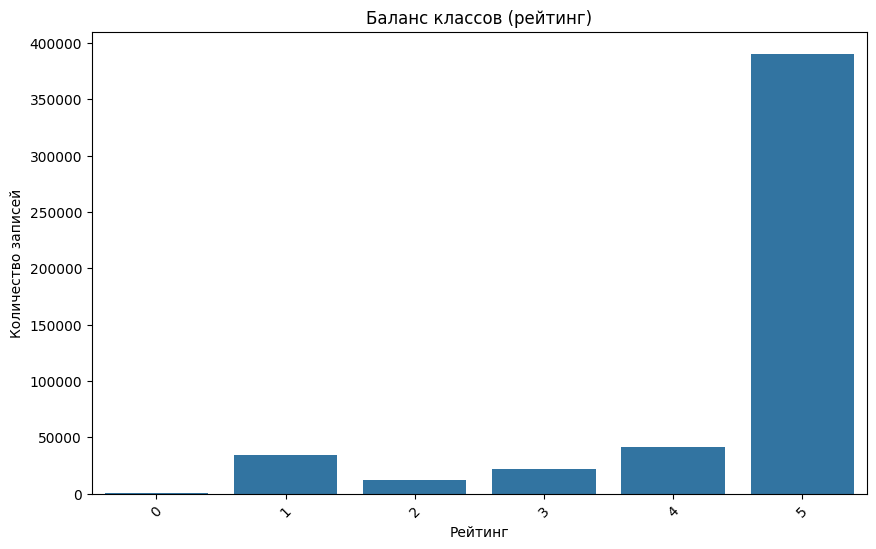

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=class_balance.index, y=class_balance.values)
plt.title('Баланс классов (рейтинг)')
plt.xlabel('Рейтинг')
plt.ylabel('Количество записей')
plt.xticks(rotation=45)
plt.show()

Наглядно видно, что класс "5 баллов" заметно превышает все другие.

## Шаг 3: Исследование других характеристик данных

### Исследование текста:
* Посчитать длину отзывов и посмотреть, как она соотносится с рейтингом.
* Проанализировать частотность слов для выявления тем и настроений.

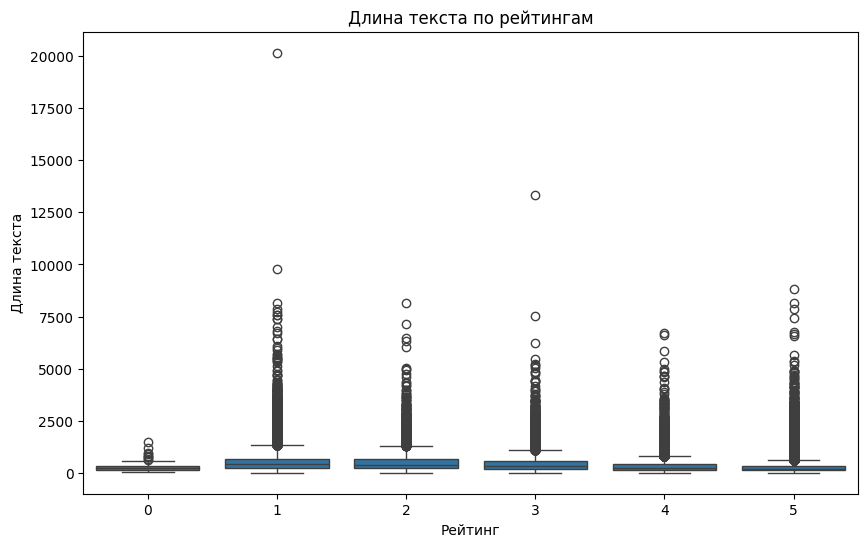

In [23]:
# Добавляем столбец с длиной текста
df['text_length'] = df['text'].apply(len)

# Смотрим на зависимость длины текста от рейтинга
plt.figure(figsize=(10, 6))
sns.boxplot(x='rating', y='text_length', data=df)
plt.title('Длина текста по рейтингам')
plt.xlabel('Рейтинг')
plt.ylabel('Длина текста')
plt.show()

Оценивая на 2 или на 5 люди желают более подробно прокомментировать свою оценку.

### Распределение длин слов объектов в сообщениях

Произведем анали на примере из 50 строк данных, чтобы слишком не нагружать систему.

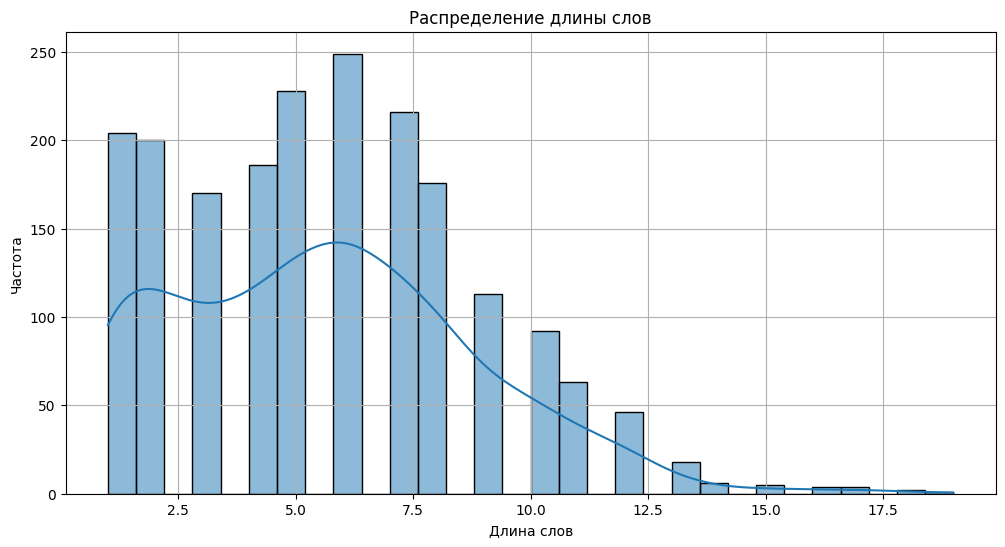

In [24]:
import re

# Выбор первых 50 строк
data = df.head(50)

# Функция для извлечения длины слов из текста
def extract_word_lengths(text):
    words = re.findall(r'\b\w+\b', text)  # Извлеките слова
    return [len(word) for word in words]

# Соберем длину слов из нужной колонки 'text'
word_lengths = []
for entry in data['text']:
    word_lengths.extend(extract_word_lengths(entry))

# Визуализация распределения длины слов
plt.figure(figsize=(12, 6))
sns.histplot(word_lengths, bins=30, kde=True)
plt.title('Распределение длины слов')
plt.xlabel('Длина слов')
plt.ylabel('Частота')
plt.grid()
plt.show()


### Количество уникальных слов

Также произведем анали на примере из 50 строк данных, чтобы слишком не нагружать систему.

In [25]:
# Функция для извлечения уникальных слов
def extract_unique_words(text_series):
    unique_words = set()
    for entry in text_series:
        # Используем регулярное выражение для извлечения слов и переводим их в нижний регистр
        words = re.findall(r'\b\w+\b', entry.lower())
        unique_words.update(words)  # Обновляем набор уникальных слов
    return unique_words

# Извлекаем уникальные слова из колонки 'text' из 50 строк данных
unique_words = extract_unique_words(data['text'])

# Подсчитываем количество уникальных слов
unique_word_count = len(unique_words)

# Результат
print(f"Количество уникальных слов на 50-ти строках данных: {unique_word_count}")

Количество уникальных слов на 50-ти строках данных: 1196


### ТОП самых часто встречающихся слов и словосочетаний

1. Очистка текста: Уберем знаки препинания, приведем все слова к нижнему регистру, удалим стоп-слова (служебные слова, которые не несут важной смысловой нагрузки) и проведем лемматизацию (если это необходимо).
2. Подсчет частоты слов: Используем метод Counter из модуля collections для подсчета количества встречающихся слов и словосочетаний.
3. Вывод ТОП-N: Получим 10 или 20 самых популярных слов и/или словосочетаний.

In [26]:
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Загрузка необходимых ресурсов NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Объединяем текстовый столбец для анализа
full_text = ' '.join(data['text'].tolist())

# Функция для очистки и токенизации текста
def clean_and_tokenize(text):
    # Приводим к нижнему регистру
   text = text.lower()
    # Удаляем знаки препинания
   text = re.sub(r'[^\w\s]', '', text)
    # Токенизация
   words = word_tokenize(text)
    # Фильтрация стоп-слов
   stop_words = set(stopwords.words('russian'))  # Используйте 'english' для английского языка
   words = [word for word in words if word not in stop_words]
   return words

# Очистка и токенизация текста
cleaned_words = clean_and_tokenize(full_text)

# Подсчет частоты слов
word_counts = Counter(cleaned_words)

# Получение ТОП-10 наиболее частых слов
top_words = word_counts.most_common(10)

# Вывод результатов
print("ТОП-10 наиболее часто встречающихся слов:")
for word, count in top_words:
    print(f"{word}: {count}")

# Для анализа словосочетаний можно использовать n-gram токенизацию
from nltk import ngrams

# Функция для подсчета словосочетаний
def get_top_phrases(words, n=2, top_n=10):
    n_grams = ngrams(words, n)
    phrase_counts = Counter(n_grams)
    return phrase_counts.most_common(top_n)

# Получение ТОП-10 словосочетаний (биграмм)
top_phrases = get_top_phrases(cleaned_words, n=2)

# Вывод результатов по словосочетаниям
print("\nТОП-10 наиболее часто встречающихся словосочетаний:")
for phrase, count in top_phrases:
    print(f"{' '.join(phrase)}: {count}")

ТОП-10 наиболее часто встречающихся слов:
очень: 37
это: 9
спасибо: 8
персонал: 7
качество: 6
всё: 6
место: 5
рекомендую: 5
большой: 4
время: 4

ТОП-10 наиболее часто встречающихся словосочетаний:
удобное расположение: 3
цены приемлемые: 2
первый делала: 2
очень мало: 2
приятная атмосфера: 2
бесплатного материала: 2
очень довольна: 2
рекомендую посещению: 2
очень вкусно: 2
вежливый персонал: 2


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### ТОПы распределения частоты слов в разрезе рейтингов

Для анализа текстов с распределением частоты слов в зависимости от рейтингов мы можем выполнить следующие шаги:

1. Импорт необходимых библиотек и загрузка данных.
2. Предобработка текста: очистка, токенизация и удаление стоп-слов.
3. Подсчет частоты слов в зависимости от рейтинга.
4. Построение топов частоты слов для каждого рейтинга.

ТОП-10 слов для рейтинга 3:
пляж: 3
окна: 2
очень: 2
3: 2
рядом: 2
московский: 1
квартал: 1
2nшумно: 1
летом: 1
ночам: 1



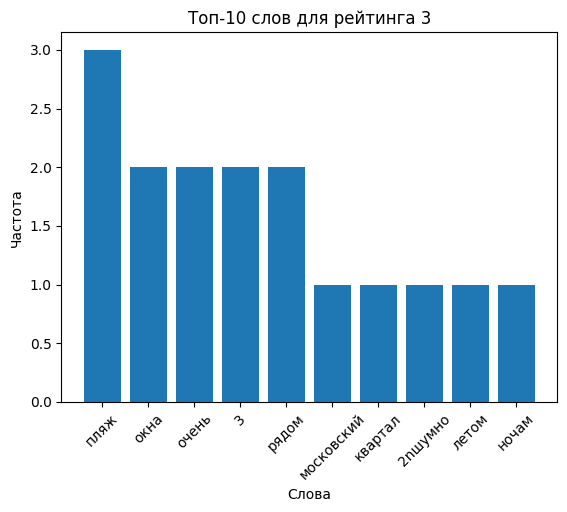

ТОП-10 слов для рейтинга 5:
очень: 28
спасибо: 8
персонал: 6
всё: 5
это: 5
хороший: 4
качество: 4
мастер: 4
понравилось: 4
место: 4



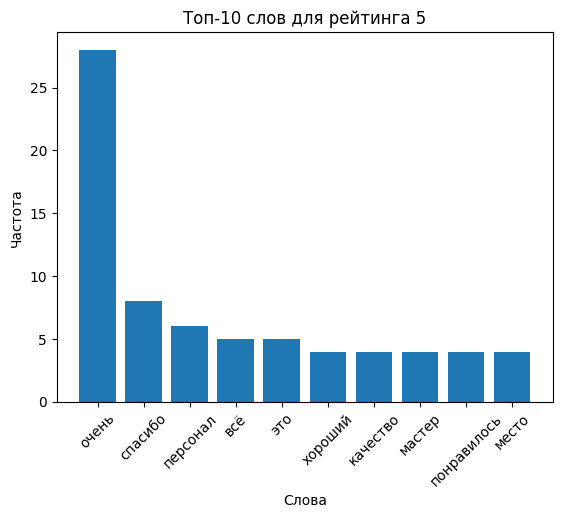

ТОП-10 слов для рейтинга 1:
доверенности: 4
застройщик: 4
очень: 3
р: 3
говорят: 2
номер: 2
свои: 2
доставка: 2
своих: 2
это: 2



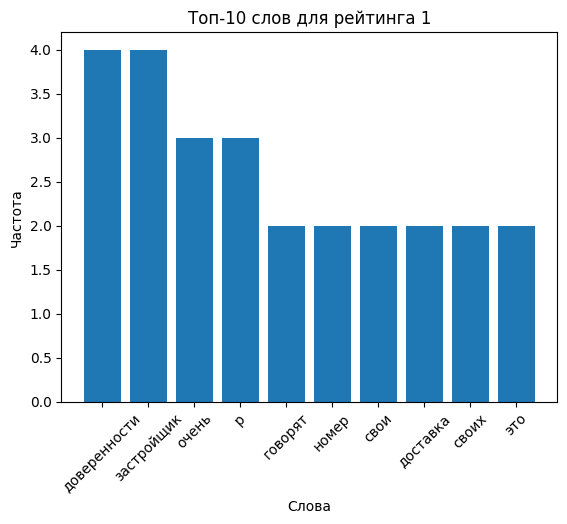

ТОП-10 слов для рейтинга 4:
очень: 4
мало: 2
хорошие: 1
условия: 1
аренды: 1
nдружелюбный: 1
персоналnно: 1
бывают: 1
неутоюбные: 1
ботинки: 1



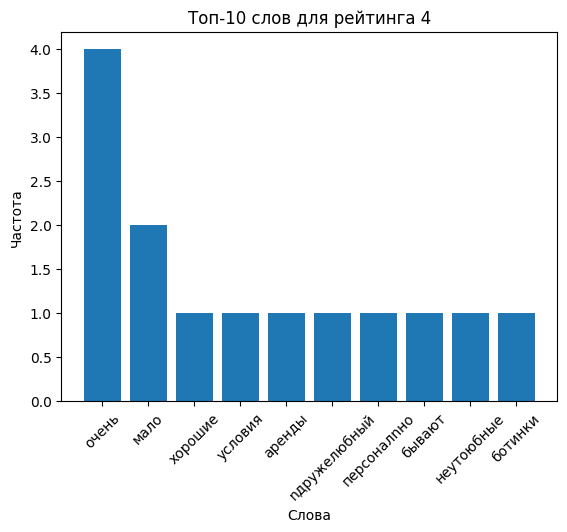

ТОП-10 слов для рейтинга 2:
хочется: 2
самый: 1
большой: 1
плюс: 1
это: 1
месторасположение: 1
набережная: 1
шикарный: 1
вид: 1
море: 1



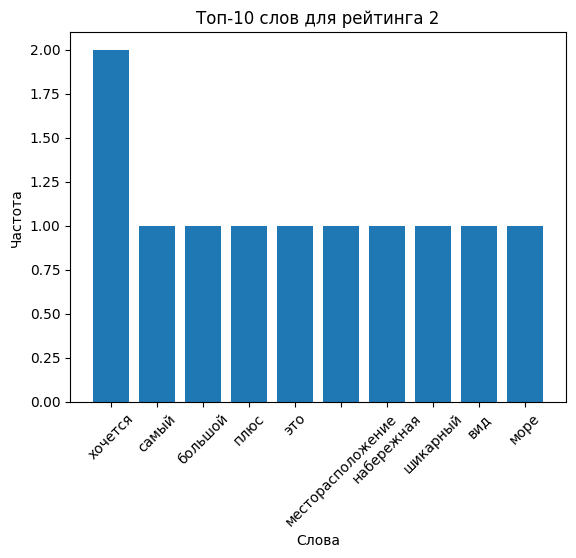

In [27]:
# Функция для предобработки текста
def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()

    # Удаление пунктуации и специальных символов
    text = re.sub(r'[^\w\s]', '', text)

    # Токенизация
    tokens = word_tokenize(text)

    # Удаление стоп-слов
    stop_words = set(stopwords.words('russian'))
    tokens = [word for word in tokens if word not in stop_words]

    return tokens

# Создание словаря для хранения частоты слов в зависимости от рейтинга
frequency_by_rating = {}

# Обработка каждого текста и подсчет частоты слов
for index, row in data.iterrows():
    rating = row['rating']
    text = row['text']

    tokens = preprocess_text(text)

    if rating not in frequency_by_rating:
        frequency_by_rating[rating] = Counter()

    frequency_by_rating[rating].update(tokens)

# Функция для создания и отображения ТОП-слов для каждого рейтинга
def plot_top_words(frequency_dict, top_n=10):
    for rating, counter in frequency_dict.items():
        print(f"ТОП-{top_n} слов для рейтинга {rating}:")
        top_words = counter.most_common(top_n)
        for word, freq in top_words:
            print(f"{word}: {freq}")
        print()

        # Построение графика
        words, freqs = zip(*top_words)
        plt.bar(words, freqs)
        plt.title(f'Топ-{top_n} слов для рейтинга {rating}')
        plt.xlabel('Слова')
        plt.ylabel('Частота')
        plt.xticks(rotation=45)
        plt.show()

# Отображаем топы для каждого рейтинга
plot_top_words(frequency_by_rating)

### Облако слов

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


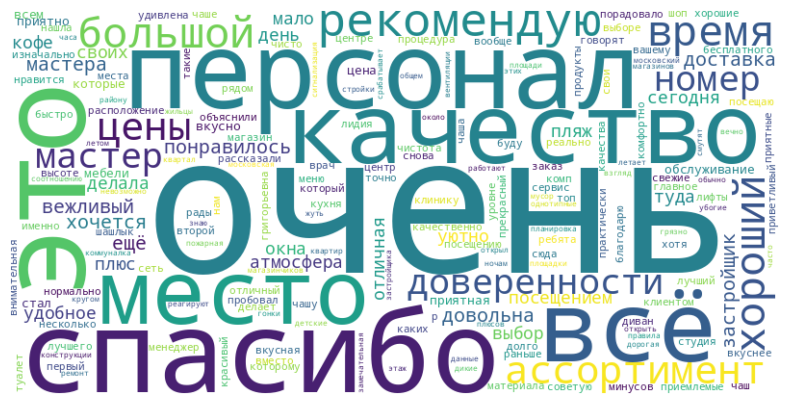

In [33]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Загрузка необходимых ресурсов NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Объединяем все тексты для создания облака слов
all_text = ' '.join(data['text'].tolist())

# Функция для предобработки текста
def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()

    # Токенизация
    tokens = word_tokenize(text)

    # Удаление стоп-слов
    stop_words = set(stopwords.words('russian'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    return ' '.join(tokens)

# Предобработка текста
cleaned_text = preprocess_text(all_text)

# Создание облака слов
wordcloud = WordCloud(font_path=None, width=800, height=400, background_color='white').generate(cleaned_text)

# Визуализация облака слов
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Убираем оси
plt.show()